In [12]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')
# Pandas и NumPy - библиотеки для работы с табличными данными и математическими операциями

# Matplotlib и Seaborn - визуализаця

# Scikit-learn предобработка и отбор признаков

In [20]:
# Загрузка данных о сердечно-сосудистых заболеваниях
df = pd.read_csv('cardio_train.csv', sep=';')

# Первичный осмотр данных
print("=== ИНФОРМАЦИЯ О ДАННЫХ ===")
print("Размерность данных:", df.shape) #Сколько строк  столбцов
print("\nПервые 5 строк:")
print(df.head())

# Базовая информация о данных
print("\n=== СТРУКТУРА ДАННЫХ ===")
print(df.info()) #Типы данных и пропуски
print("\nСтатистическое описание числовых признаков:")
print(df.describe()) #Среднее, макс, мин, ско и прочее

# Проверка качества данных
print("\n=== ПРОВЕРКА КАЧЕСТВА ДАННЫХ ===")
print("Пропущенные значения:")
print(df.isnull().sum()) #Сколько пропусков и ниже - сколько дубликатов
print(f"Количество дубликатов: {df.duplicated().sum()}")

=== ИНФОРМАЦИЯ О ДАННЫХ ===
Размерность данных: (70000, 13)

Первые 5 строк:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  

=== СТРУКТУРА ДАННЫХ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 n

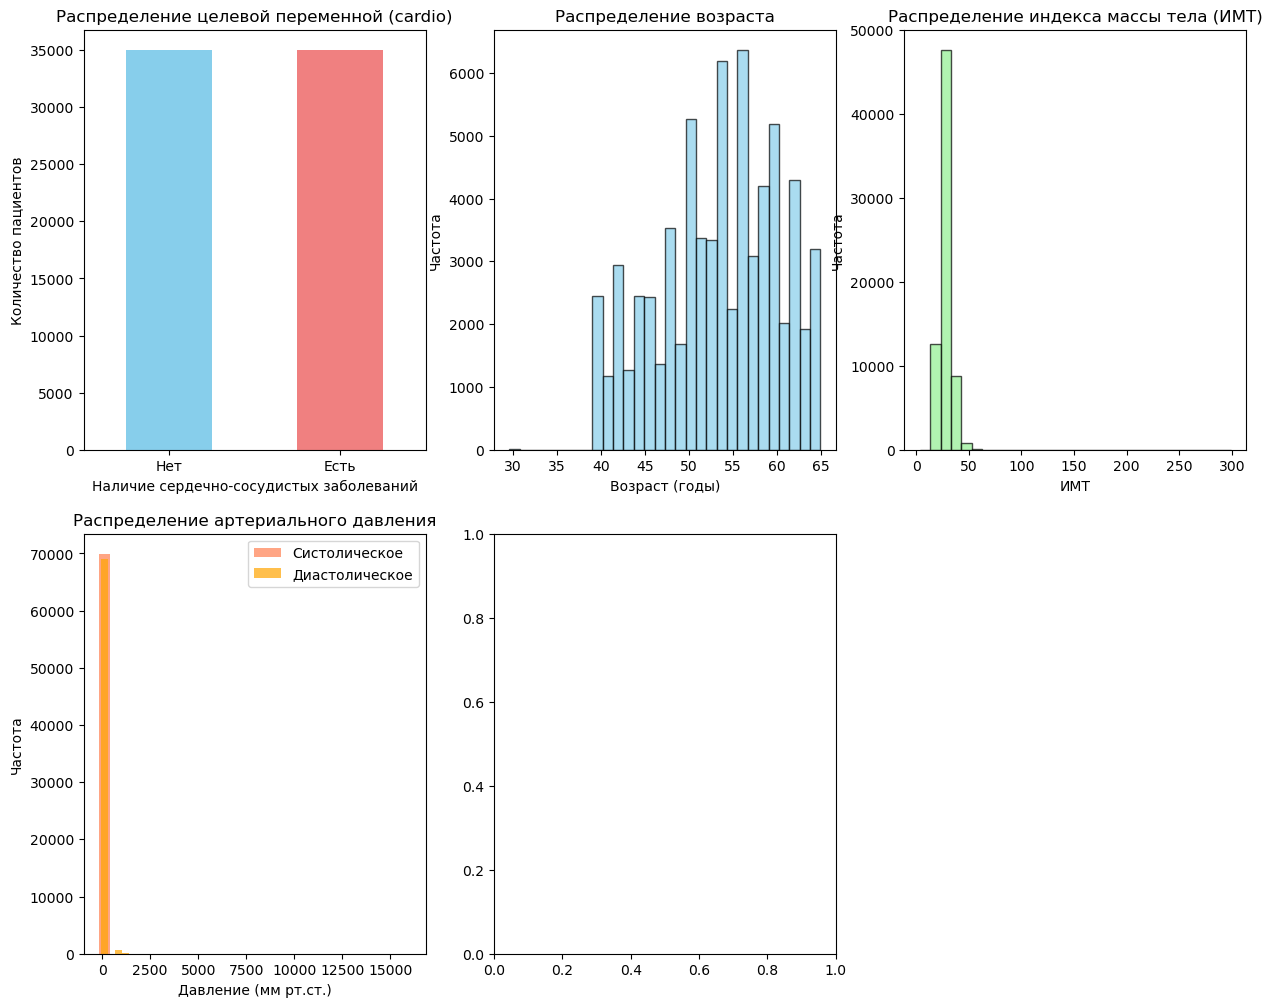

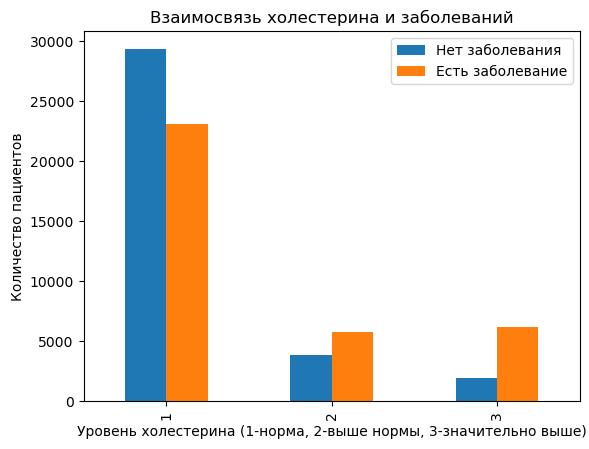

In [21]:
# Создание производных признаков для анализа
df['age_years'] = df['age'] / 365  # Преобразование возраста из дней в годы
df['bmi'] = df['weight'] / (df['height']/100)**2  # Расчет индекса массы тела

# Визуализация распределения основных признаков
plt.figure(figsize=(15, 12)) #Окно для графика 15х12

# Распределение целевой переменной
plt.subplot(2, 3, 1) #Разлиновка 2x3, 1 окно
df['cardio'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral']) #Кол-во каждого значения в столбчатой диаграмме показываем на графике
plt.title('Распределение целевой переменной (cardio)')
plt.xlabel('Наличие сердечно-сосудистых заболеваний')
plt.ylabel('Количество пациентов')
plt.xticks([0, 1], ['Нет', 'Есть'], rotation=0) #Меняем старые значения на новые + угол поворота

# Распределение возраста
plt.subplot(2, 3, 2)
plt.hist(df['age_years'], bins=30, alpha=0.7, color='skyblue', edgecolor='black') #Гистограммы с количеством интервалов
plt.title('Распределение возраста')
plt.xlabel('Возраст (годы)')
plt.ylabel('Частота')

# Распределение ИМТ
plt.subplot(2, 3, 3)
plt.hist(df['bmi'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Распределение индекса массы тела (ИМТ)')
plt.xlabel('ИМТ')
plt.ylabel('Частота')

# Распределение артериального давления
plt.subplot(2, 3, 4)
plt.hist(df['ap_hi'], bins=30, alpha=0.7, color='coral', label='Систолическое')
plt.hist(df['ap_lo'], bins=30, alpha=0.7, color='orange', label='Диастолическое')
plt.title('Распределение артериального давления')
plt.xlabel('Давление (мм рт.ст.)')
plt.ylabel('Частота')
plt.legend()

# Распределение холестерина по наличию заболевания
plt.subplot(2, 3, 5)
pd.crosstab(df['cholesterol'], df['cardio']).plot(kind='bar') #Столбчатая диаграмма перекрестная
plt.title('Взаимосвязь холестерина и заболеваний')
plt.xlabel('Уровень холестерина (1-норма, 2-выше нормы, 3-значительно выше)')
plt.ylabel('Количество пациентов')
plt.legend(['Нет заболевания', 'Есть заболевание'])

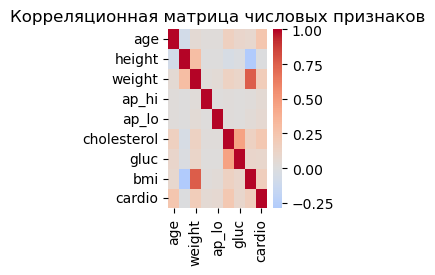

In [22]:
# Корреляционная матрица
plt.subplot(2, 3, 6)
numeric_columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'bmi']
correlation_matrix = df[numeric_columns + ['cardio']].corr() #Берем из DataFrame только выбранные столбцы + целевой признак cardio и вычисляем корреляции между всеми парами столбцов
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, fmt='.2f') #Тепловая карта
plt.title('Корреляционная матрица числовых признаков')

plt.tight_layout()
plt.show()
#Корреляция показывает, как два признака связаны друг с другом:
# correlation_matrix - данные для отображения
# annot=True - показывать числа в ячейках, у меня просто False
# Без этого были бы только цветные квадраты
# С этим видим точные значения корреляций
# cmap='coolwarm' - цветовая схема
# Синий = отрицательная корреляция
# Белый = нулевая корреляция
# Красный = положительная корреляция

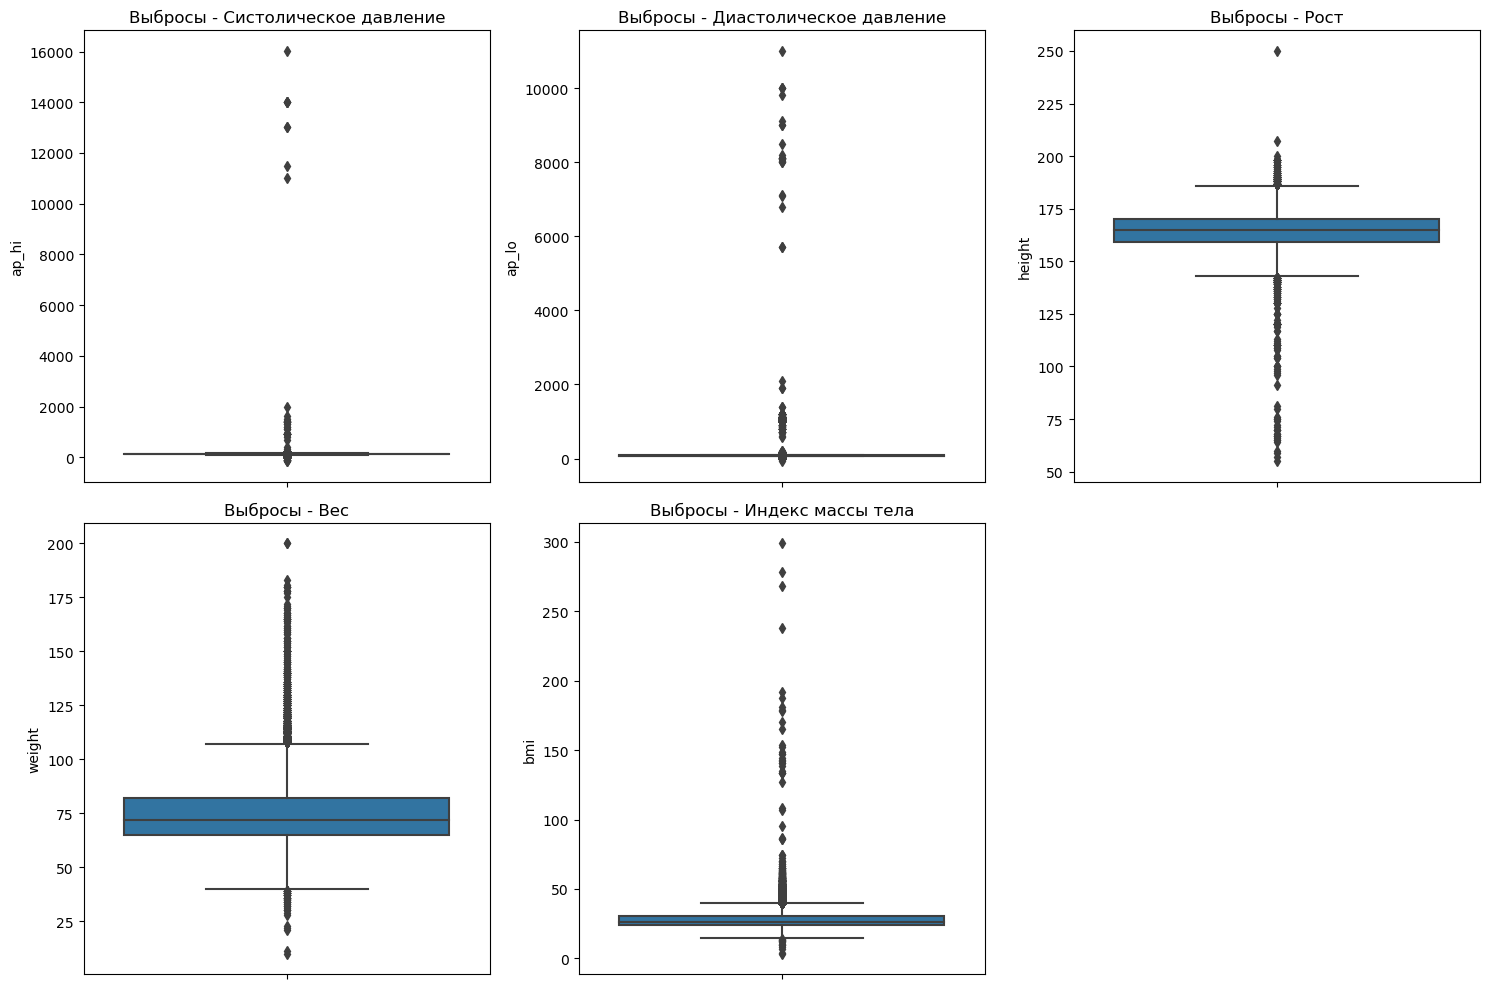

In [23]:
# Анализ выбросов в ключевых признаках
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.boxplot(data=df, y='ap_hi')
plt.title('Выбросы - Систолическое давление')

plt.subplot(2, 3, 2)
sns.boxplot(data=df, y='ap_lo')
plt.title('Выбросы - Диастолическое давление')

plt.subplot(2, 3, 3)
sns.boxplot(data=df, y='height')
plt.title('Выбросы - Рост')

plt.subplot(2, 3, 4)
sns.boxplot(data=df, y='weight')
plt.title('Выбросы - Вес')

plt.subplot(2, 3, 5)
sns.boxplot(data=df, y='bmi')
plt.title('Выбросы - Индекс массы тела')

plt.tight_layout()
plt.show()

# Основные линии:
# Q1 (25-й процентиль) - ниже этого значения 25% данных
# Q2 (Медиана) - середина данных, 50% значений ниже этой линии
# Q3 (75-й процентиль) - ниже этого значения 75% данных
# "Усы" (Whiskers):
# Показывают диапазон "нормальных" значений
# Точки за усами:
# Это ВЫБРОСЫ - аномальные значения

# Типичный вес: примерно 60-90 кг
# Выбросы: значения 10 кг (анемия) или 300 кг (тяжелое ожирение)
# Реалистичные границы: 40-180 кг

In [24]:
# Создание копии данных для обработки
df_clean = df.copy()

# Удаление ненужных столбцов
df_clean = df_clean.drop(['id'], axis=1)

print("=== ОБРАБОТКА ВЫБРОСОВ ===")
print("Статистика давления до обработки:")
print(f"Систолическое: min={df_clean['ap_hi'].min()}, max={df_clean['ap_hi'].max()}")
print(f"Диастолическое: min={df_clean['ap_lo'].min()}, max={df_clean['ap_lo'].max()}")

# Обработка выбросов в артериальном давлении
# Медицински возможные диапазоны: систолическое 80-250, диастолическое 40-150
# Рост: 140-210 см
# Вес: 40-180 кг
# ИМТ: 15-50
df_clean = df_clean[(df_clean['ap_hi'] >= 80) & (df_clean['ap_hi'] <= 250)]
df_clean = df_clean[(df_clean['ap_lo'] >= 40) & (df_clean['ap_lo'] <= 150)]
df_clean = df_clean[df_clean['ap_hi'] >= df_clean['ap_lo']]  # Систолическое всегда >= диастолическому

# Обработка выбросов в антропометрических данных
df_clean = df_clean[(df_clean['height'] >= 140) & (df_clean['height'] <= 210)]  # Рост в см
df_clean = df_clean[(df_clean['weight'] >= 40) & (df_clean['weight'] <= 180)]   # Вес в кг
df_clean = df_clean[(df_clean['bmi'] >= 15) & (df_clean['bmi'] <= 50)]          # Медицински значимый ИМТ

print(f"Размер данных после обработки выбросов: {df_clean.shape}")
print(df_clean)

=== ОБРАБОТКА ВЫБРОСОВ ===
Статистика давления до обработки:
Систолическое: min=-150, max=16020
Диастолическое: min=-70, max=11000
Размер данных после обработки выбросов: (68314, 14)
         age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0      18393       2     168    62.0    110     80            1     1      0   
1      20228       1     156    85.0    140     90            3     1      0   
2      18857       1     165    64.0    130     70            3     1      0   
3      17623       2     169    82.0    150    100            1     1      0   
4      17474       1     156    56.0    100     60            1     1      0   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
69994  21074       1     165    80.0    150     80            1     1      0   
69995  19240       2     168    76.0    120     80            1     1      1   
69997  19066       2     183   105.0    180     90            3     1      0   
69998  22431     

In [9]:
# Создание категориальных признаков на основе медицинских классификаций
print("\n=== СОЗДАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ===")

# Возрастные группы, делим на диапазоны и присваиваем категории
df_clean['age_group'] = pd.cut(df_clean['age_years'], 
                              bins=[0, 40, 50, 60, 70, 100], 
                              labels=['<40', '40-50', '50-60', '60-70', '70+'])

# Категории индекса массы тела
df_clean['bmi_category'] = pd.cut(df_clean['bmi'],
                                 bins=[0, 18.5, 25, 30, 100],
                                 labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Категории артериального давления, присваиваем категорию каждому значению
d0 (df_clean['ap_lo'] < 60), 'pressure_category'] = 'Low'

print("Распределение по возрастным группам:")
print(df_clean['age_group'].value_counts().sort_index())
print("\nРаспределение по категориям ИМТ:")
print(df_clean['bmi_category'].value_counts().sort_index())
print("\nРаспределение по категориям давления:")
print(df_clean['pressure_category'].value_counts())


=== СОЗДАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ===
Распределение по возрастным группам:
age_group
<40       1757
40-50    19218
50-60    34659
60-70    12680
70+          0
Name: count, dtype: int64

Распределение по категориям ИМТ:
bmi_category
Underweight      587
Normal         25425
Overweight     24596
Obese          17706
Name: count, dtype: int64

Распределение по категориям давления:
pressure_category
Normal    44910
High      23395
Low           9
Name: count, dtype: int64



=== КОНСТРУИРОВАНИЕ НОВЫХ ПРИЗНАКОВ ===
Закодирован признак: age_group
Закодирован признак: bmi_category
Закодирован признак: pressure_category
Созданы новые признаки: pulse_pressure, mean_arterial_pressure, risk_score

Статистика новых признаков:
       pulse_pressure  mean_arterial_pressure    risk_score
count    68314.000000            68314.000000  68314.000000
mean        45.358389               96.415698      3.423515
std         11.652281               11.004464      1.279856
min          0.000000               53.333333      2.000000
25%         40.000000               93.333333      3.000000
50%         40.000000               93.333333      3.000000
75%         50.000000              103.333333      4.000000
max        140.000000              173.333333      9.000000

=== ОТБОР ПРИЗНАКОВ ===
Топ-10 наиболее значимых признаков:
 1. age                       (F-score: 4161.78)
 2. weight                    (F-score: 2299.52)
 3. ap_hi                     (F-score: 15357.81)
 4

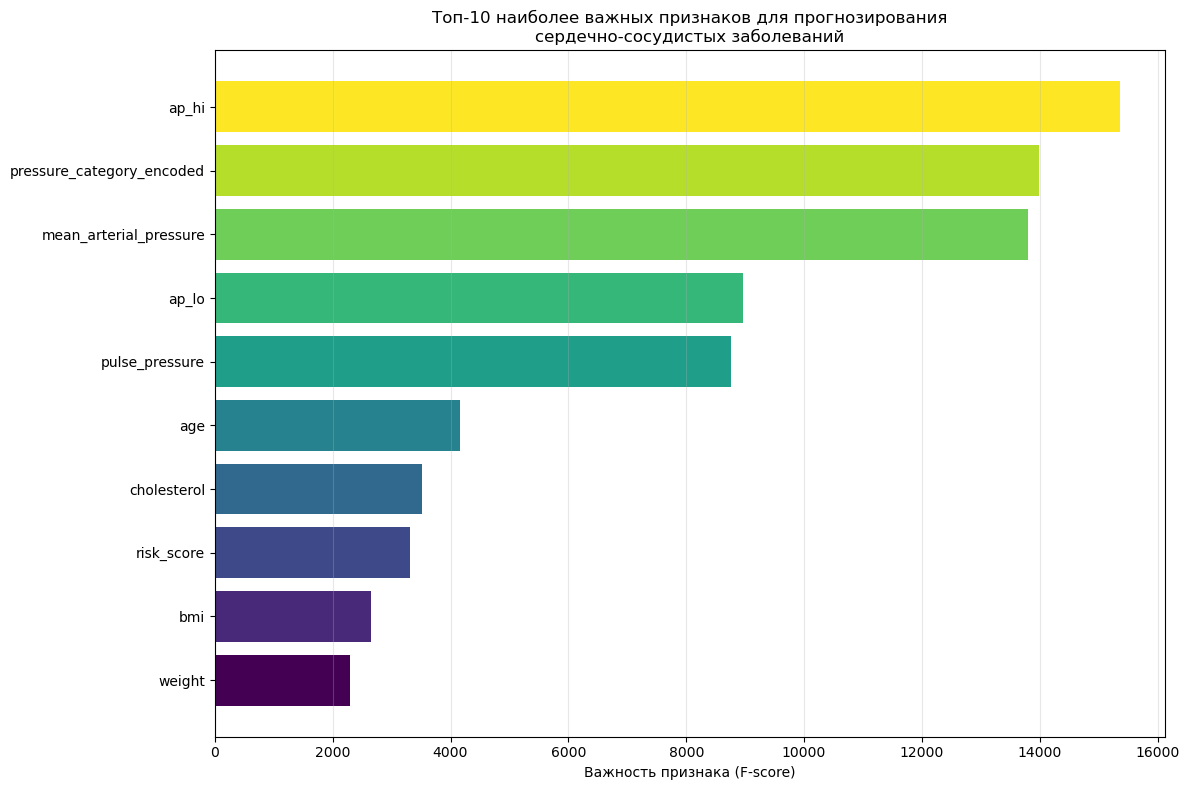

In [10]:
# Кодирование категориальных переменных для использования в моделях
# Создаем пустой словарь для хранения объектов кодировщиков
# Это нужно, чтобы потом можно было преобразовывать новые данные тем же способом
label_encoders = {}

# Список категориальных признаков, которые нужно преобразовать в числовые
# Эти признаки содержат текстовые категории или числовые коды, которые являются категориями, а не непрерывными значениями
categorical_to_encode = ['age_group', 'bmi_category', 'pressure_category']

# Проходим циклом по каждому категориальному признаку из списка
for col in categorical_to_encode:
    # Создаем объект LabelEncoder для текущего признака
    # LabelEncoder преобразует текстовые метки в числовые коды (например, 'Normal' -> 0, 'High' -> 1)
    le = LabelEncoder()
    
    # Применяем кодировщик к текущему столбцу и создаем новый столбец с суффиксом '_encoded'
    # fit_transform() сначала "обучается" на данных (запоминает соответствия), затем преобразует
    # Например: ['Low', 'Normal', 'High'] -> [0, 1, 2]
    df_clean[col + '_encoded'] = le.fit_transform(df_clean[col])
    
    # Сохраняем кодировщик в словарь по имени столбца
    # Это важно для преобразования новых данных или обратного преобразования
    label_encoders[col] = le
    
    # Выводим сообщение о успешном кодировании признака
    print(f"Закодирован признак: {col}")

# Создание физиологически значимых производных признаков
# Пульсовое давление - разница между систолическим и диастолическим давлением
# Это важный медицинский показатель, который отражает эластичность артерий
# Норма: 40-60 мм рт.ст., высокое значение может указывать на риск сердечно-сосудистых заболеваний
df_clean['pulse_pressure'] = df_clean['ap_hi'] - df_clean['ap_lo']  # Пульсовое давление

# Среднее артериальное давление - показатель перфузионного давления органов
# Рассчитывается по формуле: диастолическое давление + 1/3 пульсового давления
# Это более стабильный показатель, чем систолическое или диастолическое давление отдельно
df_clean['mean_arterial_pressure'] = df_clean['ap_lo'] + (df_clean['pulse_pressure'] / 3)  # Среднее артериальное давление

# Создание комплексного показателя риска
# Объединяем несколько факторов риска в один числовой показатель
# Каждый фактор увеличивает общий счет риска на 1 балл
df_clean['risk_score'] = (df_clean['cholesterol'] +        # Уровень холестерина (1-3): чем выше, тем больше риск
                         df_clean['gluc'] +               # Уровень глюкозы (1-3): чем выше, тем больше риск
                         df_clean['smoke'] +              # Курение (0-1): курение = +1 к риску
                         df_clean['alco'] +               # Употребление алкоголя (0-1): алкоголь = +1 к риску
                         (df_clean['age_years'] > 50).astype(int))  # Возраст старше 50 лет: True=1, False=0

# Выводим информацию о созданных новых признаках
print("Созданы новые признаки: pulse_pressure, mean_arterial_pressure, risk_score")

# Выводим статистическое описание новых признаков
# describe() показывает: count, mean, std, min, 25%, 50%, 75%, max
print("\nСтатистика новых признаков:")
print(df_clean[['pulse_pressure', 'mean_arterial_pressure', 'risk_score']].describe())

# Начинаем процесс отбора наиболее значимых признаков
print("\n=== ОТБОР ПРИЗНАКОВ ===")

# Подготовка полного списка признаков для отбора
# Включаем исходные признаки, созданные производные признаки и закодированные категориальные признаки
features_for_selection = [
    'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',     # Исходные числовые признаки
    'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi',   # Исходные и рассчитанные признаки
    'pulse_pressure', 'mean_arterial_pressure', 'risk_score',  # Созданные производные признаки
    'age_group_encoded', 'bmi_category_encoded', 'pressure_category_encoded'  # Закодированные категориальные признаки
]

# Разделяем данные на матрицу признаков (X) и целевую переменную (y)
# X содержит все признаки-предикторы, y - то, что мы хотим предсказать (наличие заболевания)
X = df_clean[features_for_selection]  # Матрица признаков (все предикторы)
y = df_clean['cardio']                # Вектор целевой переменной (0-здоров, 1-болен)

# Статистический отбор признаков с использованием ANOVA F-test
# SelectKBest выбирает k лучших признаков на основе статистического теста
# f_classif - ANOVA F-value, который проверяет, различаются ли средние значения признака между классами (здоров/болен)
# k=10 - выбираем 10 самых лучших признаков
selector = SelectKBest(score_func=f_classif, k=10)  # Выбираем 10 лучших признаков

# Обучаем селектор на данных и преобразуем матрицу признаков
# fit_transform() обучается на X,y и возвращает X только с отобранными признаками
X_selected = selector.fit_transform(X, y)

# Получение списка отобранных признаков
# get_support() возвращает булев массив, где True для отобранных признаков
# X.columns[массив] возвращает названия отобранных столбцов
selected_features = X.columns[selector.get_support()]

# Выводим список отобранных признаков с их F-оценками
# F-score показывает, насколько хорошо признак различает классы (чем выше, тем лучше)
print("Топ-10 наиболее значимых признаков:")
for i, feature in enumerate(selected_features, 1):
    # Получаем F-score для текущего признака
    # X.columns.get_loc(feature) возвращает индекс признака в исходном списке
    score = selector.scores_[X.columns.get_loc(feature)]
    # Выводим номер, название признака и его F-score с форматированием
    print(f"{i:2d}. {feature:25s} (F-score: {score:.2f})")

# Визуализация важности признаков
# Создаем новое окно для графика
plt.figure(figsize=(12, 8))

# Создаем DataFrame с названиями признаков и их оценками важности
feature_scores = pd.DataFrame({
    'feature': X.columns,      # Названия всех признаков
    'score': selector.scores_  # F-scores для всех признаков
}).sort_values('score', ascending=True)  # Сортируем по возрастанию оценки для горизонтальной диаграммы

# Строим горизонтальную столбчатую диаграмму
# Берем последние 10 признаков (топ-10 после сортировки по возрастанию)
# color=plt.cm.viridis(np.linspace(0, 1, 10)) - создает 10 разных цветов из палитры viridis
plt.barh(feature_scores['feature'][-10:], feature_scores['score'][-10:], 
         color=plt.cm.viridis(np.linspace(0, 1, 10)))

# Добавляем подписи осей и заголовок
plt.xlabel('Важность признака (F-score)')  # F-score: чем выше, тем признак важнее для различения классов
plt.title('Топ-10 наиболее важных признаков для прогнозирования\nсердечно-сосудистых заболеваний')

# Добавляем сетку на график для лучшей читаемости
# axis='x' - только вертикальные линии сетки, alpha=0.3 - прозрачность 30%
plt.grid(axis='x', alpha=0.3)

# Автоматически настраиваем отступы между элементами графика
plt.tight_layout()

# Показываем график
plt.show()

In [11]:
print("\n=== ФИНАЛЬНЫЙ НАБОР ДАННЫХ ===")

# Формирование финального набора с отобранными признаками
final_features = list(selected_features) + ['cardio']
df_final = df_clean[final_features]

print(f"Размерность финального набора данных: {df_final.shape}")
print("Признаки в финальном наборе:")
for i, col in enumerate(df_final.columns, 1):
    print(f"{i:2d}. {col}")

# Статистика финального набора
print("\nСтатистика финального набора данных:")
print(df_final.describe())
df_final.to_csv('cardio_processed.csv', index=False)
print("\nОбработанные данные сохранены в файл 'cardio_processed.csv'")


=== ФИНАЛЬНЫЙ НАБОР ДАННЫХ ===
Размерность финального набора данных: (68314, 11)
Признаки в финальном наборе:
 1. age
 2. weight
 3. ap_hi
 4. ap_lo
 5. cholesterol
 6. bmi
 7. pulse_pressure
 8. mean_arterial_pressure
 9. risk_score
10. pressure_category_encoded
11. cardio

Статистика финального набора данных:
                age        weight         ap_hi         ap_lo   cholesterol  \
count  68314.000000  68314.000000  68314.000000  68314.000000  68314.000000   
mean   19463.626431     74.004310    126.654624     81.296235      1.364186   
std     2467.910159     13.904058     16.644377      9.401502      0.678561   
min    10798.000000     40.000000     80.000000     40.000000      1.000000   
25%    17656.000000     65.000000    120.000000     80.000000      1.000000   
50%    19700.000000     72.000000    120.000000     80.000000      1.000000   
75%    21323.000000     82.000000    140.000000     90.000000      1.000000   
max    23713.000000    180.000000    240.000000    150